## Imports

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jaxquantum.codes as jqtb
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import numpy as np
from jax.scipy.optimize import minimize

plt.style.use('ggplot')

## Check CUDA devs

In [46]:
jax.devices()

[CudaDevice(id=0)]

In [47]:
jax.devices()[0].memory_stats()

{'num_allocs': 34207,
 'bytes_in_use': 69057024,
 'peak_bytes_in_use': 70495487744,
 'largest_alloc_size': 67221136640,
 'bytes_limit': 112516399104,
 'bytes_reserved': 0,
 'peak_bytes_reserved': 0,
 'largest_free_block_bytes': 0,
 'pool_bytes': 112516399104,
 'peak_pool_bytes': 112516399104}

## Compute overlap of common states

In [48]:
delta = 0.3
gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": 500})
gkp = gkp_qubit.basis["+z"]
fully_mixed = (gkp_qubit.basis["+z"].to_dm() + gkp_qubit.basis["-z"].to_dm())/2
print(jqt.overlap(gkp_qubit.basis["-z"], gkp_qubit.basis["+z"]))
print(jqt.overlap(fully_mixed, gkp_qubit.basis["+z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], gkp_qubit.basis["+z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z"], gkp_qubit.basis["+z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], gkp_qubit.basis["-z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z"], gkp_qubit.basis["-z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], fully_mixed))
print(jqt.overlap(gkp_qubit.common_gates["Z"], fully_mixed))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], jqt.basis(500, 0)))
print(jqt.overlap(gkp_qubit.common_gates["Z"], jqt.basis(500, 0)))

1.6624947335665483e-07
(0.5000000831247369+0j)
(0.929848356770922+0j)
(0.99587454530817+0.00015948913139287663j)
(-0.9298424147186958+0.00018798802240829317j)
(-0.9971281606673759-0.00034558560425609544j)
(2.971026174791605e-06-9.399401120177426e-05j)
(-0.0006268076795412093+9.304823642435834e-05j)
(0.45593812776599607+0j)
(0.45593812776599607+0j)


## Declare circuit parameters

In [49]:
kappa_min = 1/30 # 1/us
kappa_max = 1/30 #1/us
T_0_min = 1 #us
T_0_max = 6 #us

In [62]:
N = 125
T = 40
kappa_0 = 1/30
T_0 = 3000/1000
kappas = jnp.expand_dims(jnp.linspace(kappa_min, kappa_max, 1), 1)
T_0s = jnp.expand_dims(jnp.linspace(T_0_min, T_0_max, 20), 1)
kappaTs = kappas @ T_0s.transpose()
deltas = jnp.linspace(0.3, 0.6, 40)
sd_ratios = jnp.linspace(0.5, 5, 50)
times = jnp.linspace(0, T*2*T_0, T+1)

In [63]:
best = np.load("./data/best_sbs_8.npz")
delta = best["deltas"][-1]
sd_ratio = best["sd_ratio"]
delta_idx = np.argmin(np.abs(deltas-delta))
sd_ratio_idx = np.argmin(np.abs(sd_ratios-sd_ratio))
err_prob = 1-jnp.exp(-kappas[0]*T_0s[8])
delta = 0.483

## Sweep circuit parameters

In [64]:
@jax.jit
def sBs_round(initial_state, alphas, phis, thetas, reset_p, err_prob):
    N = initial_state.space_dims[1]
    reg = jqtc.Register([2, N])

    cirq = jqtc.Circuit.create(reg, layers=[])

    cirq.append(jqtc.Ry(jnp.pi / 2), 0)
    cirq.append(jqtc.CD(N, alphas[0]), [0, 1])
    cirq.append(jqtc.Ry(phis[0]), 0)
    cirq.append(jqtc.Rx(thetas[0]), 0)
    cirq.append(jqtc.CD(N, alphas[1]), [0, 1])
    cirq.append(jqtc.Ry(phis[1]), 0)
    cirq.append(jqtc.Rx(thetas[1]), 0)
    cirq.append(jqtc.CD(N, alphas[2]), [0, 1])
    cirq.append(jqtc.IP_Reset(reset_p[0], reset_p[1]), 0)

    cirq.append(jqtc.Amp_Damp(N, err_prob, 20), 1)

    res = jqtc.simulate(cirq, initial_state, mode='kraus')
    final_state = res[-1][-1]

    return final_state

In [65]:
def sbs_batch(delta, sd_ratio, reset_p, err_prob):
    l = jnp.sqrt(2*jnp.pi)
    epsilon = jnp.sinh(delta*delta)*l

    alphas_real = jnp.array([epsilon/2, 0., sd_ratio*epsilon/2, 0., l, 0.])
    alphas_imag = jnp.array([0., -l, 0., epsilon/2, 0., sd_ratio*epsilon/2])
    alphas = alphas_real + alphas_imag * 1.j
    phis = jnp.array([0., 0., 0., 0.])
    thetas = jnp.array([jnp.pi/2, -jnp.pi/2, jnp.pi/2, -jnp.pi/2])
    exp_X = []
    exp_Z = []
    for axis in ["Z", "X"]:
        gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": N})
        gkp = gkp_qubit.basis["+z"] if axis == "Z" else gkp_qubit.basis["+x"]

        initial_state = jqt.basis(2, 0) ^ gkp
        current_state = initial_state

        if axis=="Z":
            exp_Z.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["Z_0"], current_state.ptrace(1))))
        else:
            exp_X.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["X_0"], current_state.ptrace(1))))
        
        for _ in range(T):

            current_state = sBs_round(current_state, alphas[0:3], phis[0:2],
                                      thetas[0:2], reset_p, err_prob)
            current_state = sBs_round(current_state, alphas[3:6], phis[2:4],
                                      thetas[2:4], reset_p, err_prob)
            if axis=="Z":
                exp_Z.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["Z_0"], current_state.ptrace(1))))
            else:
                exp_X.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["X_0"], current_state.ptrace(1))))
    
    return jnp.array([exp_Zi / 2 + exp_Xi / 2 for (exp_Zi, exp_Xi) in zip(exp_Z, exp_X)])

In [66]:
def fit_t1(times, amps):
    def exponential(a):
        return jnp.sum((a[0]*jnp.exp(a[1]*times)-amps)**2)
    scipy_res= minimize(exponential, jnp.array([0., 0.]), method="BFGS")
    return scipy_res

In [67]:
reset_p_eg = jnp.linspace(0, 0.3, 40)
reset_p_ee = jnp.linspace(0, 0.3, 40)

In [68]:
reset_p_eg_mg, reset_p_ee_mg = jnp.meshgrid(reset_p_eg, reset_p_ee)

In [69]:
reset_p_mg = jnp.stack((reset_p_eg_mg, reset_p_ee_mg), axis=2)

In [70]:
sbs = jax.vmap(jax.vmap(sbs_batch, in_axes=(None, None, 0, None), out_axes=0), in_axes=(None, None, 0, None), out_axes=0)
fit_t1_vmap = jax.vmap(jax.vmap(fit_t1, (None, 0), 0), (None, 0), 0)

In [71]:
result = jnp.abs(sbs(delta, sd_ratio, reset_p_mg, err_prob))

In [72]:
coeff = fit_t1_vmap(times, result).x
t1 = -1/(coeff[:, :, 1])

Text(0.5, 1.0, 'Imperfect Reset; $\\Delta=0.483, T_{sBs}/2 = 3.0 \\mu s, \\kappa^-1=30 \\mu s $')

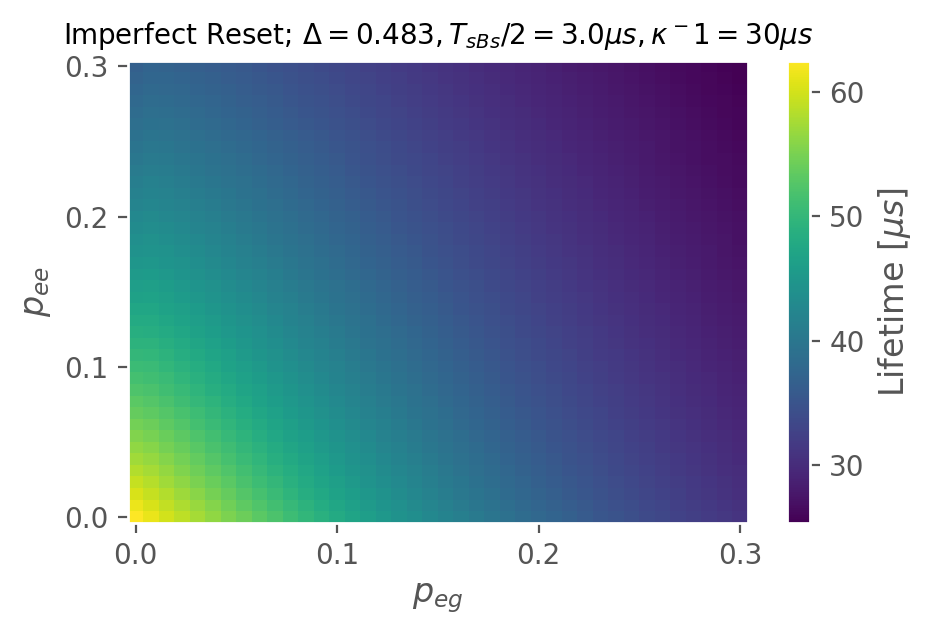

In [73]:
fig, ax = plt.subplots(1, figsize=(5, 3), dpi=200)
handle = ax.pcolormesh(reset_p_eg_mg, reset_p_ee_mg, t1, shading='nearest')
fig.colorbar(handle, ax=ax, label="Lifetime $[\mu s]$", ticks=[30, 40, 50, 60])
ax.set_xlabel(r"$p_{eg}$")
ax.set_ylabel(r"$p_{ee}$")
ax.set_xticks(np.linspace(0, 0.3, 4))
ax.set_yticks(np.linspace(0, 0.3, 4))
ax.set_title(f"Imperfect Reset; $\\Delta={delta:.3f}, T_{{sBs}}/2 = {T_0:.1f} \mu s, \kappa^{-1}={1/(kappas[0][0]):.0f} \mu s $", fontsize=10)

Text(0.5, 0.98, '$T_L=17.565727806729836\\;\\mu s$')

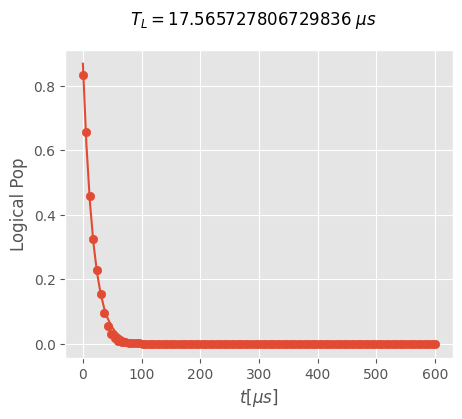

In [31]:
fig, axs = plt.subplots(1, figsize=(5, 4))

axs.scatter(times, result)
fit_f = coeff[0]*jnp.exp(coeff[1]*times)
axs.plot(times, fit_f)
axs.set_xlabel("$t [\mu s]$")
axs.set_ylabel("Logical Pop")
fig.suptitle(f"$T_L={t1}\;\mu s$")